# Tiny NeRF

This is an implementation of TinyNeRF (a simplified version of NeRF) in PyTorch.
<br>

The main difference of TinyNeRF and NeRF is the exclusion of hierarchical sampling and that the input of the neural network is only a position (x,y,z) +positional encoding.

In [1]:
import os, sys
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Plotting

In [3]:
def show_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_rays(samples, origin):

  fig = go.Figure()
  fig.add_trace(
      go.Scatter3d(
          x=origin[:, 0],
          y=origin[:, 1],
          z=origin[:, 2],
          mode="markers",
          name="camera",
      )
  )

  # show query points
  samples = samples.reshape((-1, 3))
  samples = samples.detach().cpu().numpy()
  fig.add_trace(
      go.Scatter3d(
          x=samples[:, 0],
          y=samples[:, 1],
          z=samples[:, 2],
          mode="markers",
          name="samples",
          marker=dict(size=1, opacity=0.5),
      )
  )

  fig.show()

## Loading Data

In [5]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
# if not os.path.exists('nerf_example_data.zip'):
#     !wget https://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip

--2024-02-03 01:36:59--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-02-03 01:36:59--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M   872KB/s    in 8.3s    

2024-02-03 01:37:08 (1.47 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



torch.Size([106, 100, 100, 3]) torch.Size([106, 4, 4]) tensor(138.8889, device='cuda:0', dtype=torch.float64)


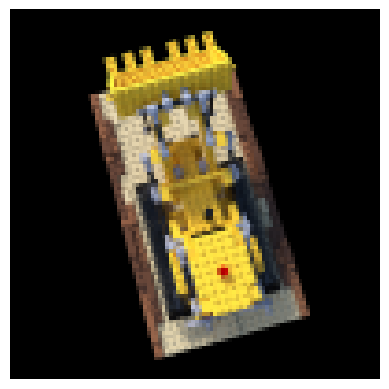

In [92]:
data = np.load('tiny_nerf_data.npz')
images = torch.from_numpy(data['images']).to(device, dtype=torch.float32)
height, width = images.shape[1:3]

poses = torch.from_numpy(data['poses']).to(device).to(device, dtype=torch.float32)
focal = torch.tensor(data['focal']).to(device)

# sample = dataset[np.random.randint(len(dataset))]
test_image = images[100 + np.random.randint(6)]
print(images.shape, poses.shape, focal)
show_image(test_image.cpu().detach().numpy())

## Rays

Takes the image plane's size and camera parameters and computes $r(t)$, ray origin and direction. You can sample points on the ray using sample function.

In [77]:
class CameraRay:
  def __init__(self, width, height, focal, RT_matrix):
    # Create rays for all pixels of the image plane of the camera
    # This just creates a grid of (i,j) for i in [1, 100] and j in [1, 100]

    j, i = torch.meshgrid(
        torch.arange(width).to(RT_matrix),
        torch.arange(height).to(RT_matrix)
      )

    # Create directions with respect to the camera's center
    relative_directions = torch.stack([(i - width * .5) / focal,
                              -(j - height * .5) / focal,
                              -torch.ones_like(i)
                            ], dim=-1)

    # Extract extrinsic parameters from the matrix
    R = RT_matrix[:3, :3]
    T = RT_matrix[:3, -1]

    # To get the absolute direction of the rays, i.e. in the world
    self.directions = torch.sum(relative_directions[..., None, :] * R, dim=-1)

    # Just repeat the origin which is T for ease of calculation
    self.origins = T.expand(self.directions.shape)

  # First samples some rays, then samples n points on each sampled ray
  def sample(self, near, far, n):
    dists = torch.linspace(near, far, n).to(device)

    # So that the selected points are not deterministic
    dists = dists + torch.rand(list(self.origins.shape[:-1]) + [n]).to(device) * (far - near) / n

    samples = (
        self.origins[..., None, :]
        + self.directions[..., None, :] * dists[..., None]
    )
    return samples, dists


rays = CameraRay(images.shape[2], images.shape[1], focal, poses[10])

samples, _ = rays.sample(2, 6, 5)

origin = rays.origins.reshape((-1, 3))
origin = origin.detach().cpu().numpy()

plot_rays(samples, origin)

## Dataset

In [14]:
from torch.utils.data import DataLoader, Dataset

class SceneDataset(Dataset):
  def __init__(self, images, poses, focal, near=2, far=6, n_samples=5, max_len=100):
    self.images = images[:max_len, ...]
    self.poses = poses[:max_len, ...]
    self.focal = focal

    height = images.shape[1]
    width = images.shape[2]
    self.near = near
    self.far = far
    self.n_samples = n_samples

    self.rays = [CameraRay(width, height, focal, pose) for pose in poses]

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    samples, dists = self.rays[idx].sample(self.near, self.far, self.n_samples)
    return self.images[idx], samples, dists

## Utils

### Positional Encoding
positional encoding is used due to the small size of the input of model (x,y,z)

In [52]:
def get_positional_encoding(x, length=6):
  out = [x]

  for i in range(length):
    out.append(torch.sin(2.0**i * x))
    out.append(torch.cos(2.0**i * x))

  return torch.cat(out, dim=-1)

### Volume Rendering
the most important function for rendering the scene
<br>
<br>
As the real volume rendering funcion is a continuous, we use an approximator for this function which can be used by sampling.

In [78]:
def cumprod_exclusive(tensor):
    dim = -1
    cumprod = torch.cumprod(tensor, dim)
    cumprod = torch.roll(cumprod, 1, dim)
    cumprod[..., 0] = 1.0

    return cumprod

def render_volume_density(rgbs, ray_origins, dists):
    sigma_a = torch.nn.functional.relu(rgbs[..., 3])
    rgb = torch.sigmoid(rgbs[..., :3])

    one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)

    dists = torch.cat(
        (
            dists[..., 1:] - dists[..., :-1],
            one_e_10.expand(dists[..., :1].shape),
        ),
        dim=-1,
    )

    alpha = 1.0 - torch.exp(-sigma_a * dists)
    weights = alpha * cumprod_exclusive(1.0 - alpha + 1e-10)

    rgb_map = (weights[..., None] * rgb).sum(dim=-2)

    return rgb_map

## Model

In [83]:
class Model(torch.nn.Module):
    def __init__(self, inp=39, hidden=256):
        super(Model, self).__init__()
        self.l1 = torch.nn.Linear(inp, hidden)
        self.l2 = torch.nn.Linear(hidden, hidden)
        self.l3 = torch.nn.Linear(hidden, hidden)
        self.l4 = torch.nn.Linear(hidden, 4)
        self.relu = torch.nn.functional.relu

    def forward(self, x):
      x = self.l1(x)
      x = self.relu(x)
      x = self.l2(x)
      x = self.relu(x)
      x = self.l3(x)
      x = self.relu(x)
      x = self.l4(x)
      return x

## Train

In [90]:
class config:
    TRAIN_MAX_LEN = 100
    BATCH_SIZE = 32 * 1024
    EPOCHS = 1000
    NEAR = 2 # n
    FAR = 6 # f
    POS_ENC_LEN = 6 # L
    TEST_EVERY = 25
    LEARNING_RATE = 5e-3
    SAMPLES_PER_RAY = 64


Loss: 0.2188205122947693:   0%|          | 0/1000 [00:00<?, ?it/s]

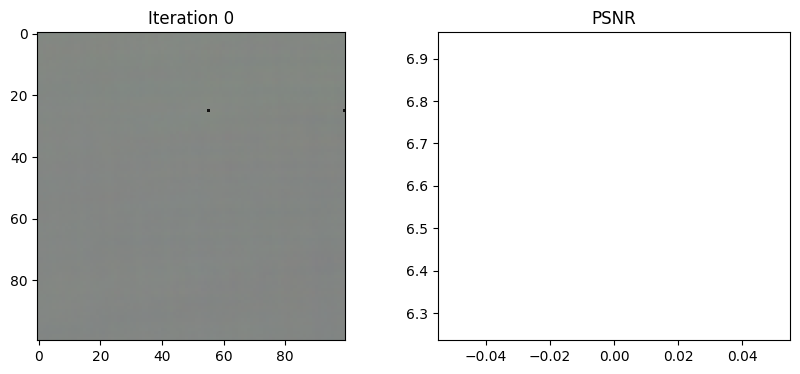

Loss: 0.08424998819828033:   2%|▎         | 25/1000 [00:06<03:47,  4.28it/s]

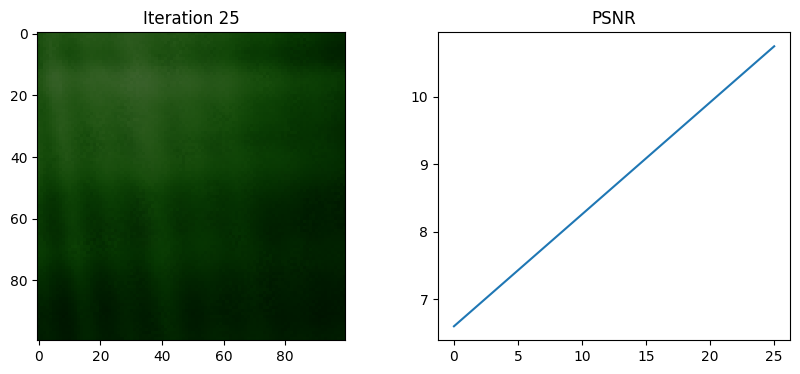

Loss: 0.03412509337067604:   5%|▌         | 50/1000 [00:12<03:43,  4.26it/s]

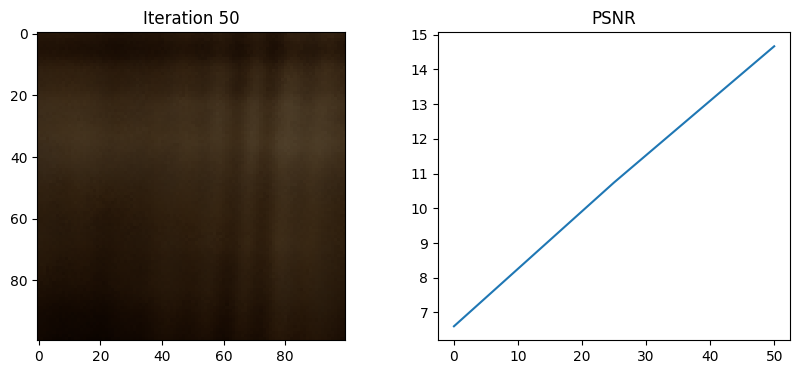

Loss: 0.04499189928174019:   8%|▊         | 75/1000 [00:19<03:37,  4.26it/s]

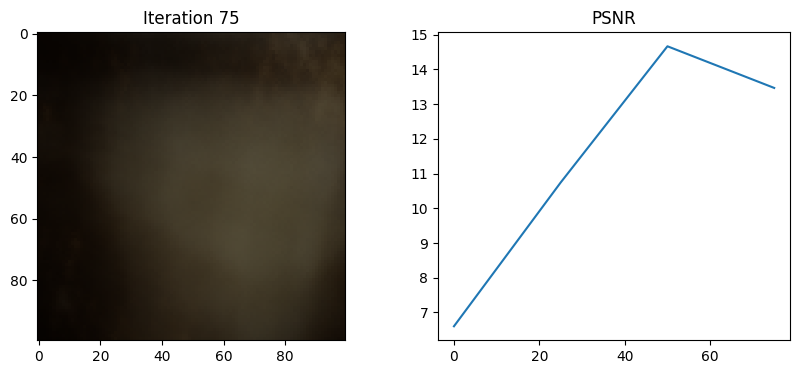

Loss: 0.0470239594578743:  10%|█         | 100/1000 [00:25<03:25,  4.37it/s] 

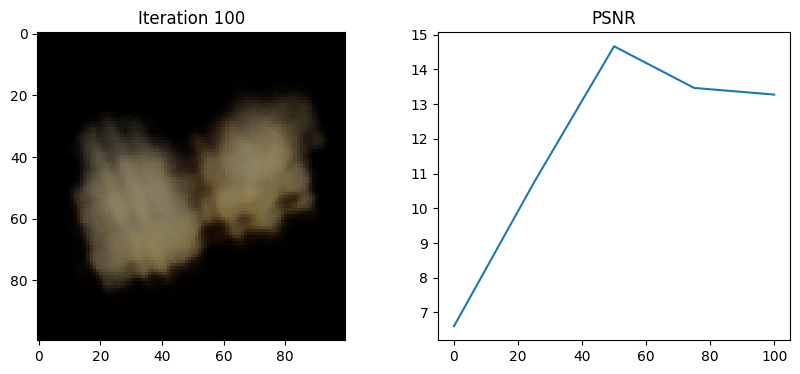

Loss: 0.030292320996522903:  12%|█▎        | 125/1000 [00:31<03:16,  4.46it/s]

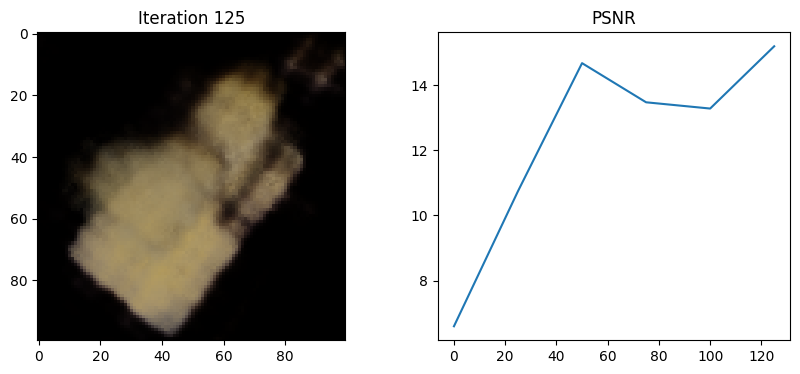

Loss: 0.012266452424228191:  15%|█▌        | 150/1000 [00:37<03:09,  4.48it/s]

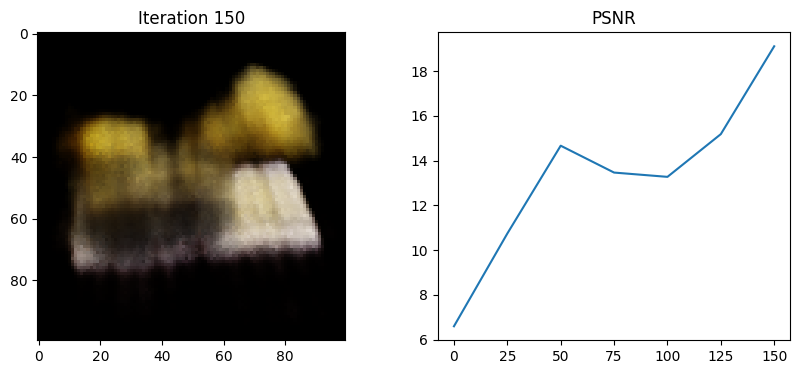

Loss: 0.008039857260882854:  18%|█▊        | 175/1000 [00:43<03:03,  4.50it/s]

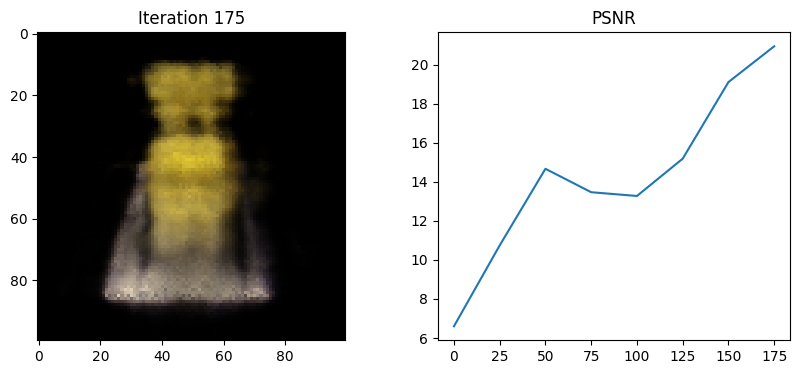

Loss: 0.010551413521170616:  20%|██        | 200/1000 [00:49<02:58,  4.49it/s]

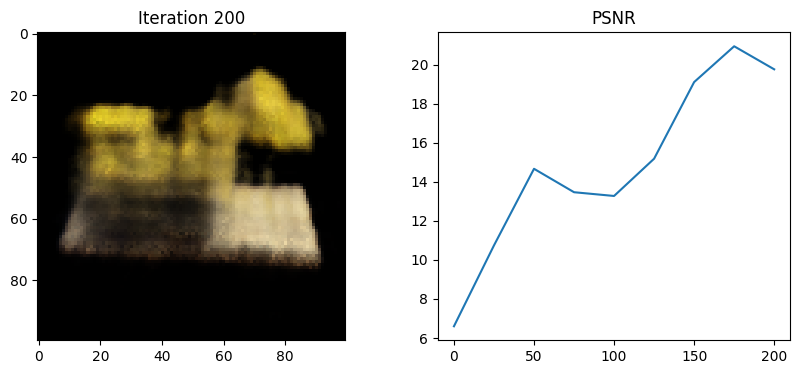

Loss: 0.01319120079278946:  22%|██▎       | 225/1000 [00:55<02:50,  4.55it/s] 

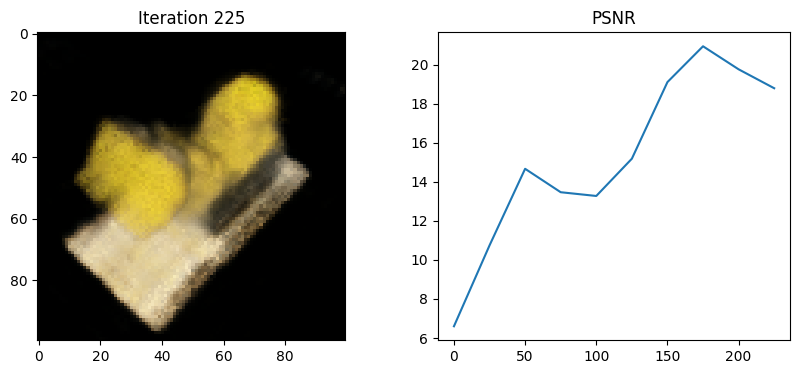

Loss: 0.005315382033586502:  25%|██▌       | 250/1000 [01:01<02:46,  4.49it/s]

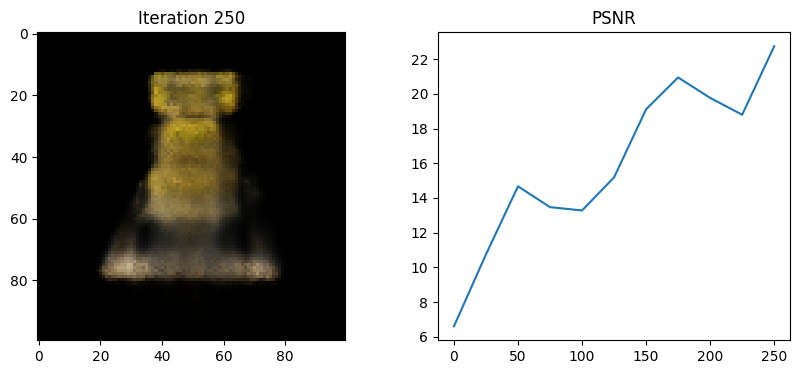

Loss: 0.004944834858179092:  28%|██▊       | 275/1000 [01:07<02:41,  4.50it/s]

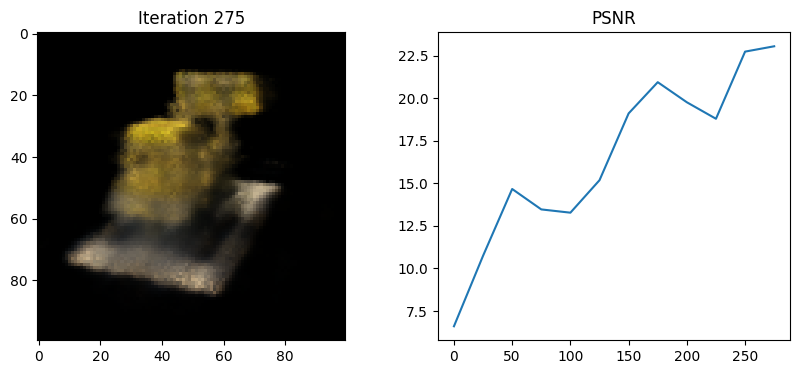

Loss: 0.009171044453978539:  30%|███       | 300/1000 [01:13<02:50,  4.09it/s]

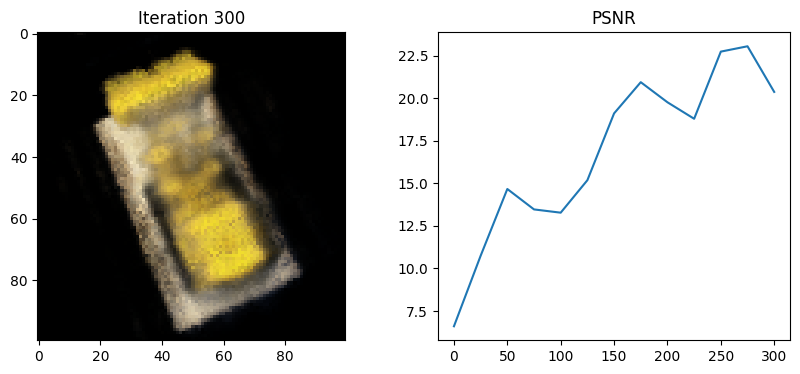

Loss: 0.006501703057438135:  32%|███▎      | 325/1000 [01:20<02:29,  4.51it/s]

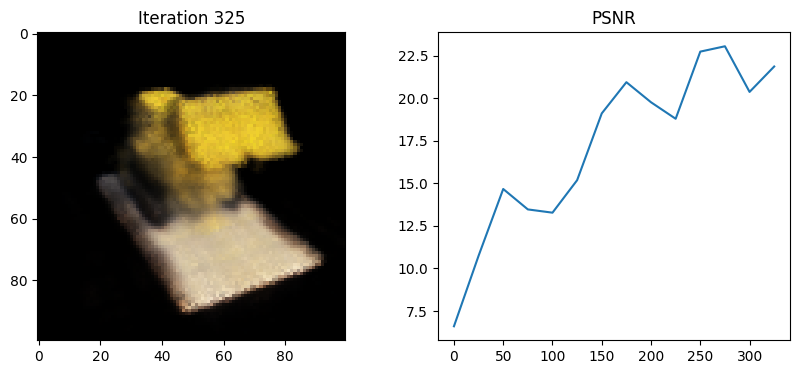

Loss: 0.007498299237340689:  35%|███▌      | 350/1000 [01:26<02:28,  4.38it/s]

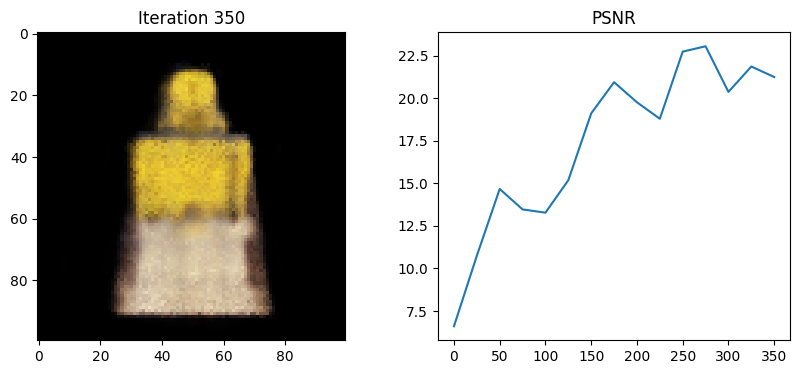

Loss: 0.004839020781219006:  38%|███▊      | 375/1000 [01:32<02:18,  4.51it/s]

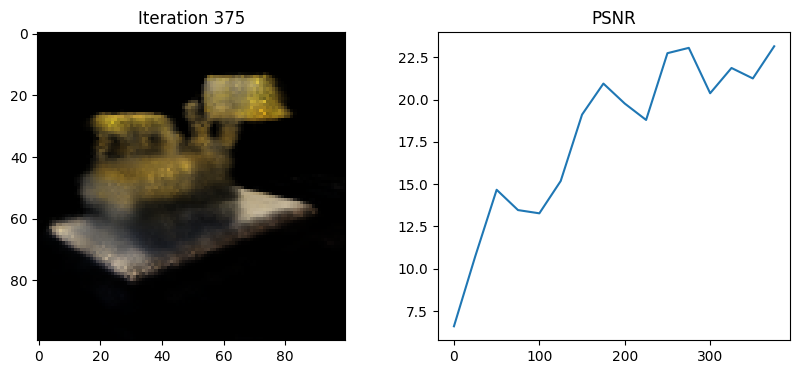

Loss: 0.006379459053277969:  40%|████      | 400/1000 [01:38<02:13,  4.48it/s]

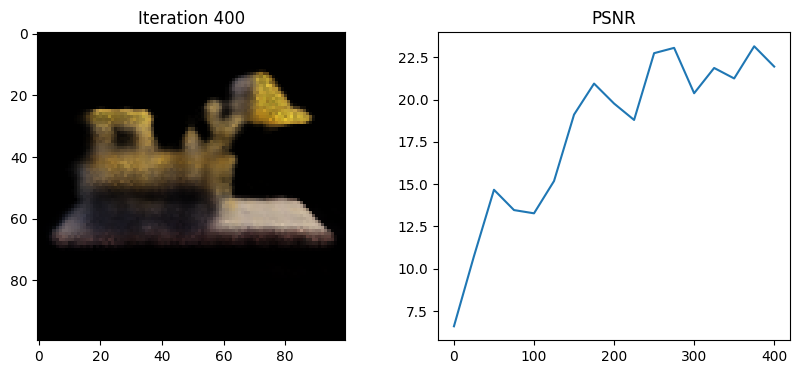

Loss: 0.005686963442713022:  42%|████▎     | 425/1000 [01:44<02:07,  4.50it/s]

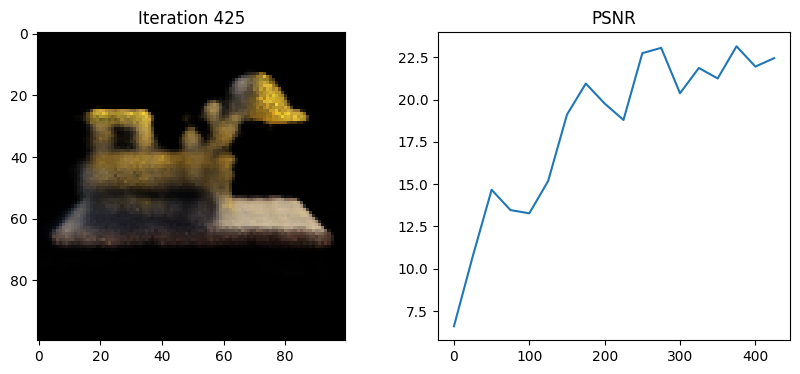

Loss: 0.008367891423404217:  45%|████▌     | 450/1000 [01:50<02:01,  4.52it/s]

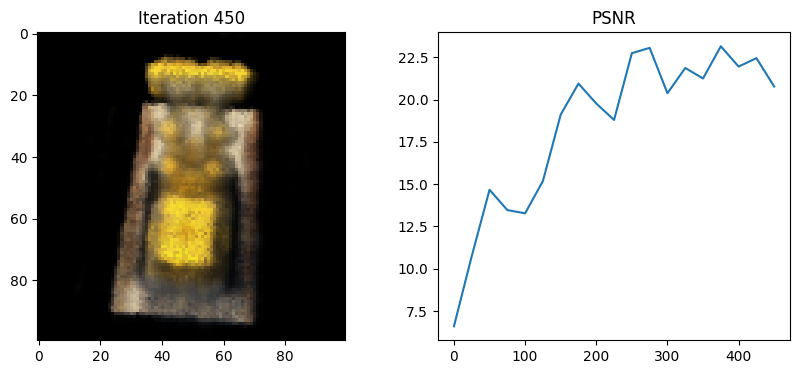

Loss: 0.0094608748331666:  48%|████▊     | 475/1000 [01:56<01:57,  4.48it/s]  

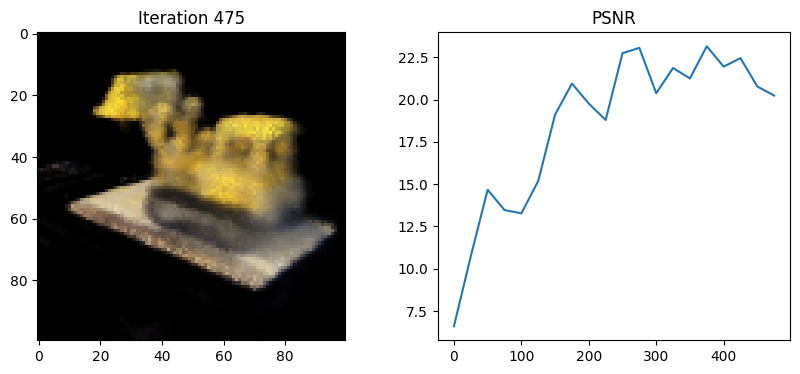

Loss: 0.006893231067806482:  50%|█████     | 500/1000 [02:02<01:50,  4.54it/s]

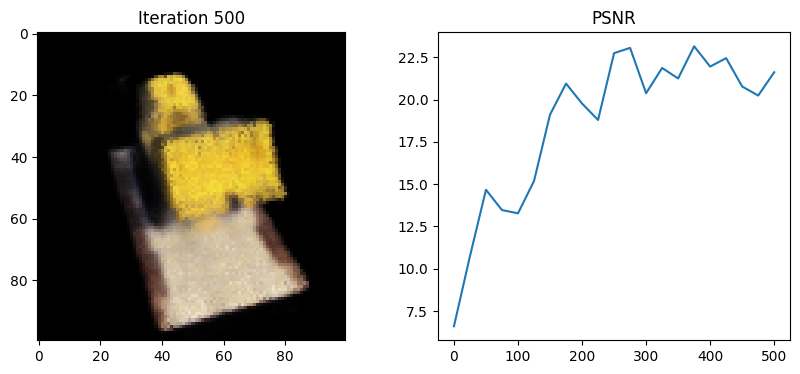

Loss: 0.0066359397023916245:  52%|█████▎    | 525/1000 [02:08<01:44,  4.53it/s]

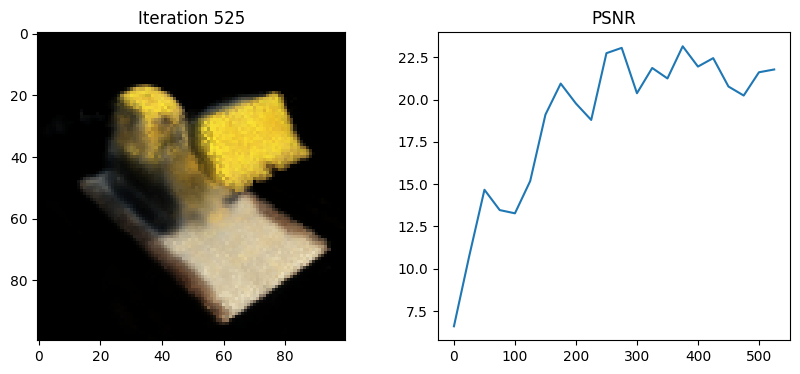

Loss: 0.007651581894606352:  55%|█████▌    | 550/1000 [02:13<01:39,  4.52it/s] 

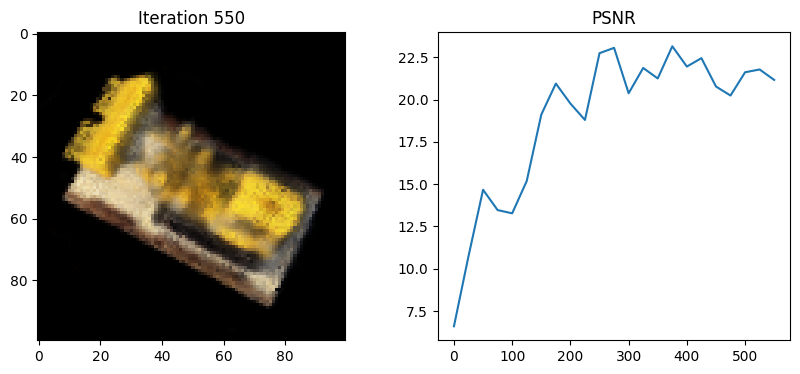

Loss: 0.0047827549278736115:  57%|█████▊    | 575/1000 [02:19<01:33,  4.53it/s]

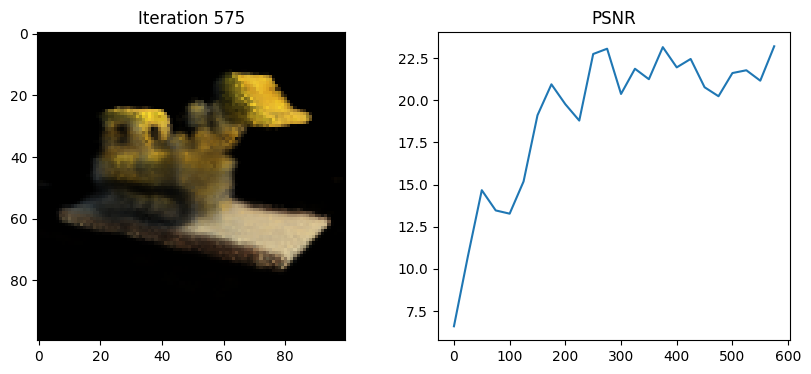

Loss: 0.007159448694437742:  60%|██████    | 600/1000 [02:25<01:28,  4.53it/s] 

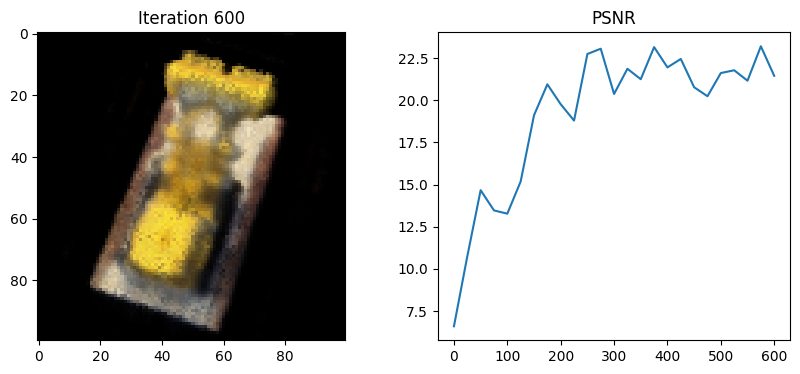

Loss: 0.006957517471164465:  62%|██████▎   | 625/1000 [02:31<01:26,  4.32it/s]

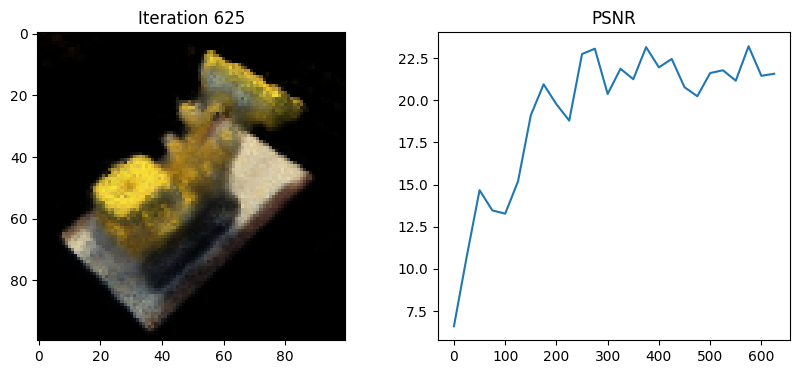

Loss: 0.005700067616999149:  65%|██████▌   | 650/1000 [02:37<01:16,  4.55it/s]

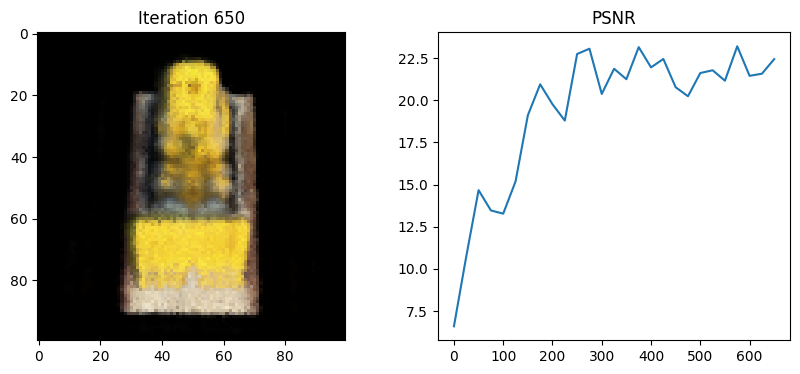

Loss: 0.003395708743482828:  68%|██████▊   | 675/1000 [02:44<01:13,  4.42it/s]

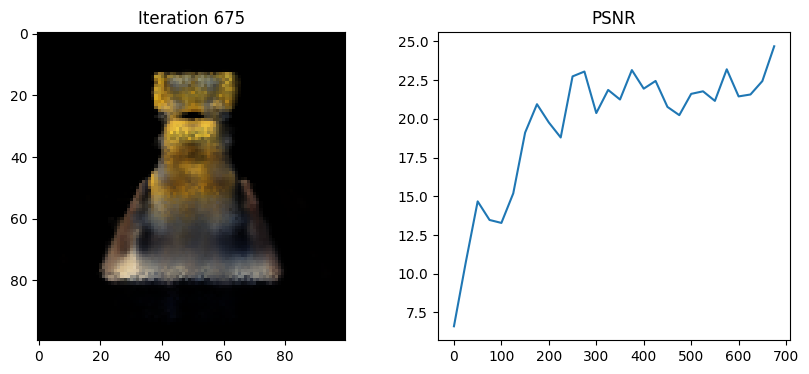

Loss: 0.007210197858512402:  70%|███████   | 700/1000 [02:50<01:06,  4.54it/s]

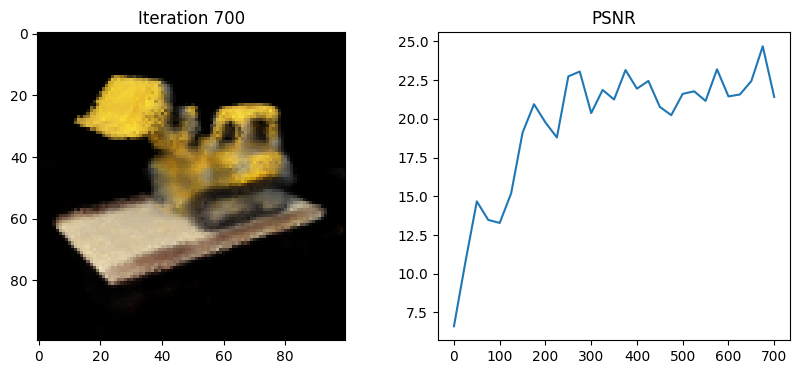

Loss: 0.007454681675881147:  72%|███████▎  | 725/1000 [02:56<01:01,  4.49it/s]

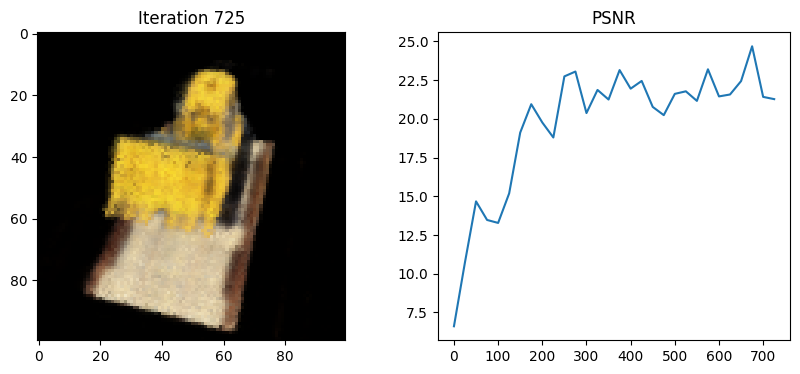

Loss: 0.007883792743086815:  75%|███████▌  | 750/1000 [03:03<00:56,  4.42it/s]

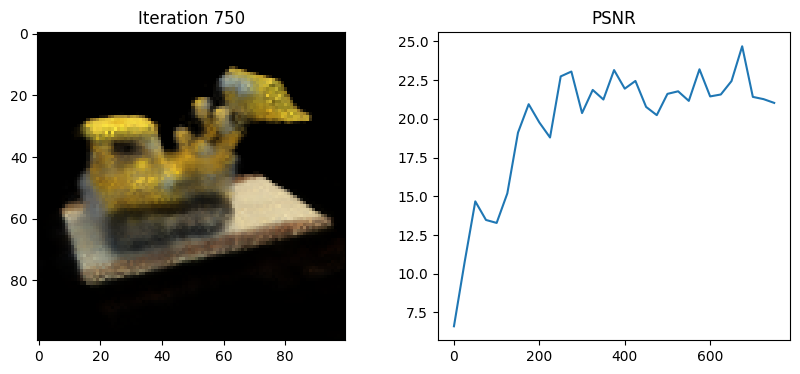

Loss: 0.008661437779664993:  78%|███████▊  | 775/1000 [03:09<00:49,  4.55it/s]

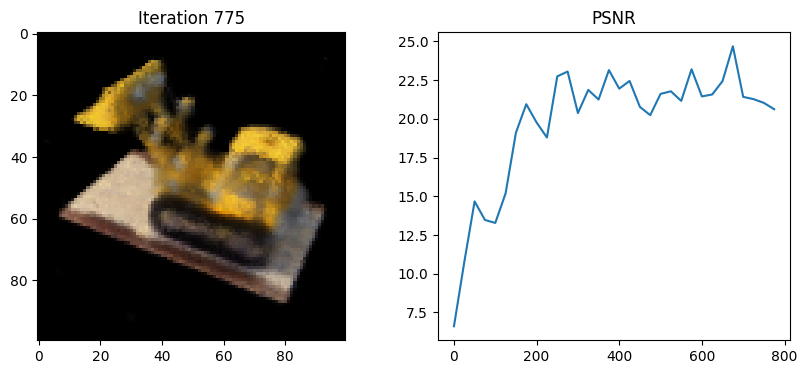

Loss: 0.0056710937060415745:  80%|████████  | 800/1000 [03:15<00:45,  4.38it/s]

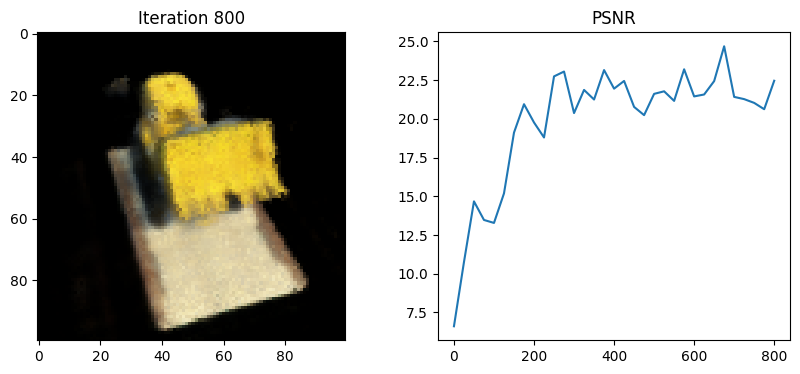

Loss: 0.006044796667993069:  82%|████████▎ | 825/1000 [03:21<00:39,  4.47it/s] 

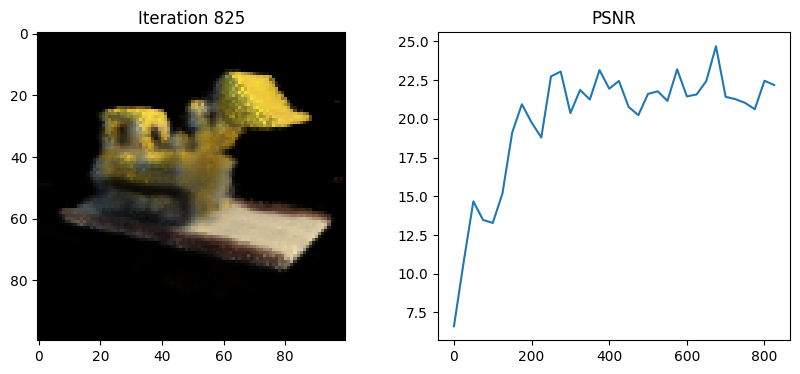

Loss: 0.007167401723563671:  85%|████████▌ | 850/1000 [03:27<00:33,  4.51it/s]

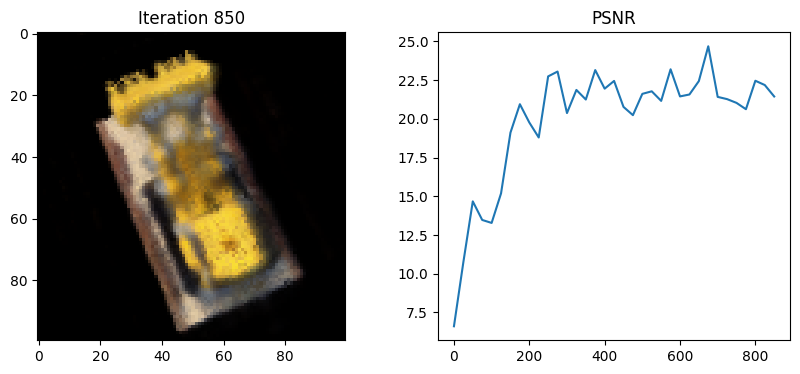

Loss: 0.007931980304419994:  88%|████████▊ | 875/1000 [03:33<00:28,  4.41it/s]

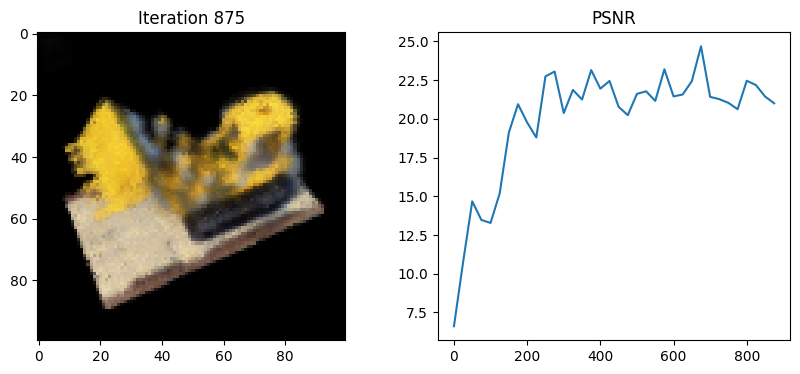

Loss: 0.0067160287871956825:  90%|█████████ | 900/1000 [03:39<00:22,  4.50it/s]

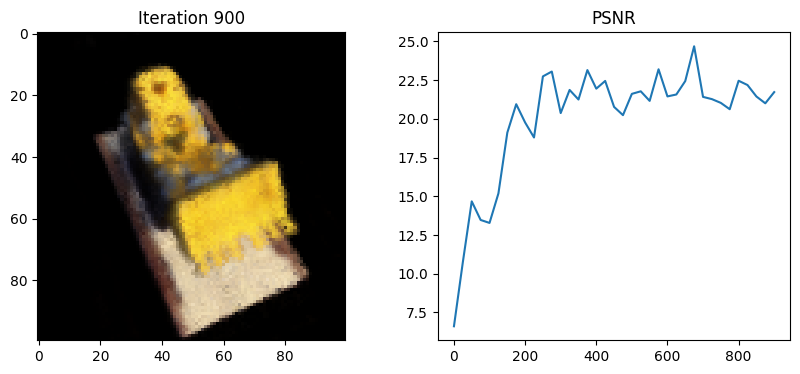

Loss: 0.006745610851794481:  92%|█████████▎| 925/1000 [03:46<00:16,  4.45it/s] 

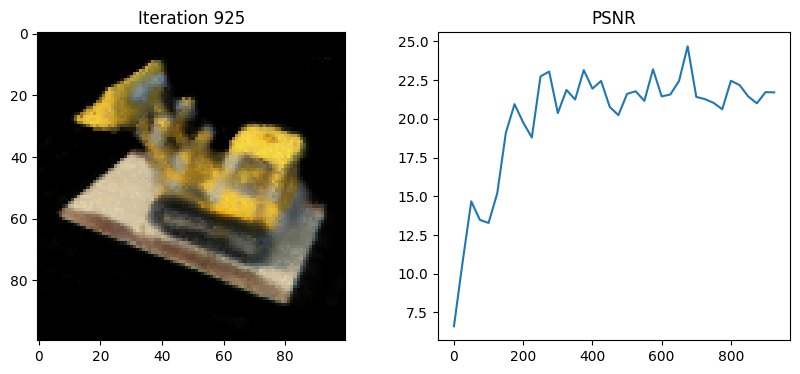

Loss: 0.004998078569769859:  95%|█████████▌| 950/1000 [03:52<00:11,  4.51it/s]

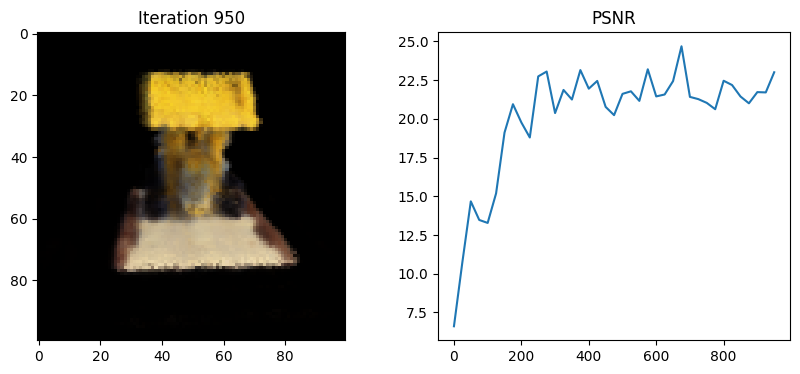

Loss: 0.003862663172185421:  98%|█████████▊| 975/1000 [03:58<00:05,  4.50it/s]

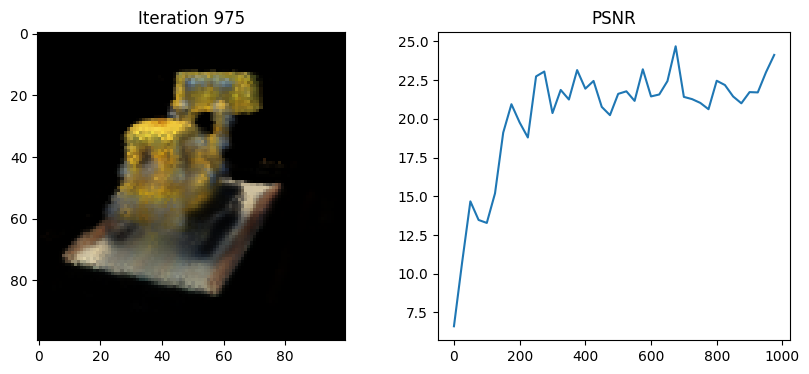

Loss: 0.003862663172185421: 100%|██████████| 1000/1000 [04:04<00:00,  4.09it/s]


In [91]:
from torch.optim import Adam

model = Model((1 + 2 * config.POS_ENC_LEN)*3, hidden=256).to(device)
# model = NeRF(6, 256).to(device)

optimizer = Adam(model.parameters(), lr=config.LEARNING_RATE)

dataset = SceneDataset(images, poses, focal, near=config.NEAR, far= config.FAR,
                       n_samples=config.SAMPLES_PER_RAY, max_len=config.TRAIN_MAX_LEN)

criterion = nn.MSELoss()
model.train()

psnr = []
cnt = 0

with tqdm(range(config.EPOCHS)) as tq:
  for epoch in tq:
    idx = np.random.randint(len(dataset))
    # print(idx)
    image, samples, dists = dataset[idx]

    samples_shape = samples.shape
    samples = samples.reshape((-1, 3))

    inputs = get_positional_encoding(samples, length=config.POS_ENC_LEN)

    # print(inputs.shape)

    def batchify(inputs):
      return [inputs[i:i + config.BATCH_SIZE] for i in range(0, inputs.shape[0], config.BATCH_SIZE)]

    all_predictions = []
    for batch in batchify(inputs):
        all_predictions.append(model(batch))

    all_predictions = torch.cat(all_predictions, dim=0)

    radiance_field = all_predictions.reshape(list(samples_shape[:-1]) + [4])
    # print(radiance_field.shape)

    rendered_scene = render_volume_density(radiance_field, dataset.rays[idx].origins, dists)

    loss = criterion(rendered_scene, image)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    if epoch % config.TEST_EVERY == 0:
      tq.set_description(f"Loss: {loss.item()}")
      psnr.append(-10.0 * np.log(loss.item()) / np.log(10))
      cnt += 1

      plt.figure(figsize=(10, 4))
      plt.subplot(121)
      plt.imshow(rendered_scene.detach().cpu().numpy())
      plt.title(f"Iteration {epoch}")
      plt.subplot(122)

      plt.plot([x*config.TEST_EVERY for x in range(cnt)], psnr)
      plt.title("PSNR")
      plt.show()

# Test

## 360 Video

In [97]:
import tensorflow as tf

trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w

frames = []
# test_dataset = SceneDataset(images[100:], poses[100:], focal, near=config.NEAR, far= config.FAR,
#                        n_samples=config.SAMPLES_PER_RAY)
# test_idx = 0

for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = torch.tensor(pose_spherical(th, -30., 4.).numpy()).to(device)
    rays = CameraRay(width, height, focal, c2w)
    samples, dists = rays.sample(config.NEAR, config.FAR, config.SAMPLES_PER_RAY)

    samples_shape = samples.shape

    radiance_field = model(get_positional_encoding(samples,
                                                   length=config.POS_ENC_LEN)).reshape(list(samples_shape[:-1]) + [4])

    rendered_scene = render_volume_density(radiance_field, rays.origins, dists).cpu().detach().numpy()

    frames.append((255*np.clip(rendered_scene,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

100%|██████████| 120/120 [00:11<00:00, 10.31it/s]


In [98]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)